In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [89]:
import pandas as pd
import itertools
from collections import namedtuple
from plotnine import *
from multiprocessing import Pool
from IPython.core import display as ICD
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import Imputer
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix, classification_report, log_loss, accuracy_score

In [1069]:
pd.set_option('display.max_columns', None)

animals_binary = pd.read_csv('binary_imputed_train.csv')
ot = animals_binary.pop('OutcomeType')
animals_binary.insert(0, 'OutcomeType', ot)
#animals_binary.drop(['AnimalID', 'OutcomeSubtype'], axis=1, inplace=True)
ICD.display(animals_binary.head())

animals = pd.read_csv('imputed_train.csv')
animals = animals.iloc[:, [2] + range(7, len(animals.columns))]
animals.drop(['AnimalID', 'OutcomeSubtype'], axis=1, inplace=True)
ot = animals.pop('OutcomeType')
animals.insert(0, 'OutcomeType', ot)
ICD.display(animals.head())

,OutcomeType,HasName_0,Year_0,Year_1,Month_0,Month_1,Month_2,Month_3,Weekday_0,Weekday_1,Weekday_2,Hour_0,Hour_1,Hour_2,Hour_3,Hour_4,WeekofYear_0,WeekofYear_1,WeekofYear_2,WeekofYear_3,WeekofYear_4,WeekofYear_5,DayofMonth_0,DayofMonth_1,DayofMonth_2,DayofMonth_3,DayofMonth_4,isHoliday_0,AgeinDays_0,AgeinDays_1,AgeinDays_2,AgeinDays_3,AgeinDays_4,AgeinDays_5,LifeStage_0,LifeStage_1,LifeStage_2,BernoulliSex_0,BernoulliSex_1,AvgWeight(pounds)_0,AvgWeight(pounds)_1,AvgWeight(pounds)_2,AvgWeight(pounds)_3,AvgWeight(pounds)_4,AvgWeight(pounds)_5,AvgWeight(pounds)_6,SizeScore(1to5)_0,SizeScore(1to5)_1,SizeScore(1to5)_2,Intelligent_0,Intelligent_1,Intelligent_2,Friendliness_0,Friendliness_1,AvgAge_0,AvgAge_1,AvgAge_2,AvgAge_3,MixType_0,MixType_1,Hair_0,Hair_1,BlendedColor_0,BlendedColor_1,BlendedColor_2,BlendedColor_3,BlendedColor_4,ReducedPattern_0,ReducedPattern_1,ReducedPattern_2
0,Return_to_owner,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Euthanasia,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1
2,Adoption,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
3,Transfer,1,0,0,0,0,1,1,0,1,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
4,Transfer,1,0,1,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,1,0


,OutcomeType,AnimalType,HasName,Year,Month,Weekday,Hour,WeekofYear,DayofMonth,isHoliday,AgeinDays,LifeStage,BernoulliSex,AvgWeight(pounds),SizeScore(1to5),Intelligent,Friendliness,AvgAge,MixType,Hair,BlendedColor,ReducedPattern
0,Return_to_owner,Dog,1.0,2014,2,2,18,7,12,False,365.0,Puppy/Kitten,Neutered Male,28.0,2.0,5.0,4.0,13.0,Mix,Short,rosybrown,BiColor
1,Euthanasia,Cat,1.0,2013,10,6,12,41,13,True,365.0,Puppy/Kitten,Spayed Female,9.0,1.0,3.0,3.0,12.0,Mix,Short,tan,Tabby
2,Adoption,Dog,1.0,2015,1,5,12,5,31,True,730.0,Young Adult,Neutered Male,60.0,4.0,3.0,2.0,12.0,Mix,Short,silver,BiColor
3,Transfer,Cat,0.0,2014,7,4,19,28,11,True,21.0,Infant,Intact Male,9.0,1.0,3.0,3.0,16.0,Mix,Short,rosybrown,Solid
4,Transfer,Dog,0.0,2013,11,4,12,46,15,False,730.0,Young Adult,Neutered Male,14.0,2.0,4.0,4.0,15.0,Cross,Short,tan,Solid


In [72]:
animals.rename(columns={'AvgWeight(pounds)': 'AvgWeight', 'SizeScore(1to5)': 'SizeScore'}, inplace=True)

continuous=[
    'AgeinDays', 
    'AvgWeight', 
    'AvgAge'
]

# Ensure order is correct if treated as continuous (value of dictonary). Doing 1-hot doesn't seem to work as
# well with RF. But order matters a lot here (i.e. LifeStage won't work properly if not set as below -- the 
# order it automatically creates is not in the order of the stages). Commenting out the features that don't 
# work after trail and error (on RF).
discrete = dict(
    AnimalType = None,
    HasName = None,
    Year = None,
    Month = range(12),
    Weekday = range(7),
    Hour = [0] + range(5, 24),
    WeekofYear = range(53),
    DayofMonth = range(31), # why does this one matter, seems it shouldn't -- need to try without
#    isHoliday = None,
#    LifeStage = ["Unknown", "Infant", "Puppy/Kitten", "Young Adult", "Adult", "Senior", "Geriatric"],
    BernoulliSex = ['Intact Male', 'Intact Female', 'Neutered Male', 'Spayed Female'],
#    SizeScore = range(1, 6),
#    Intelligent = range(2, 6),
#    Friendliness = range(1, 6),
    MixType = ['Cross', 'Mix', 'Pure'],
#    Hair = ['Long', 'Medium', 'Short'],
#    BlendedColor = None,
#    ReducedPattern = ['Solid', 'BiColor', 'TriColor', 'Tabby', 'Mertle', 'Point', 'Smoke']
)

In [1095]:
encode_discrete_as_one_hot = False

df = pd.DataFrame(animals.iloc[:, 0].copy())
for c in animals.columns[1:]:
    if c in continuous:        
        df[c] = animals[c]
    elif c in discrete.keys():        
        if encode_discrete_as_one_hot:
            df = pd.concat([df, pd.get_dummies(pd.Categorical(animals[c]), prefix=c)], axis=1)            
        else:
            df[c] = pd.Categorical(animals[c], categories=discrete[c]).codes
            
df.head()
    

,OutcomeType,HasName,Month,Weekday,Hour,WeekofYear,DayofMonth,AgeinDays,BernoulliSex,AvgAge
0,Return_to_owner,1,2,2,14,7,12,365.0,2,13.0
1,Euthanasia,1,10,6,8,41,13,365.0,3,12.0
2,Adoption,1,1,5,8,5,-1,730.0,2,12.0
3,Transfer,0,7,4,15,28,11,21.0,0,16.0
4,Transfer,0,11,4,8,46,15,730.0,2,15.0


In [1133]:
#df_bin = pd.concat([animals_binary, df.loc[:, ['AgeinDays', 'AvgWeight', 'AvgAge']].copy()], axis=1)
#df_bin = df_bin.loc[:, df_bin.columns.drop(list(df_bin.filter(regex='Age|Avg')))]
#df_bin = df_bin.loc[:, df_bin.columns.drop(list(df_bin.filter(regex='isHoliday|Hair|LifeStage|Size')))]
#df_bin.head()
df_bin = animals_binary.copy()
df_bin.head()

,OutcomeType,HasName_0,Year_0,Year_1,Month_0,Month_1,Month_2,Month_3,Weekday_0,Weekday_1,Weekday_2,Hour_0,Hour_1,Hour_2,Hour_3,Hour_4,WeekofYear_0,WeekofYear_1,WeekofYear_2,WeekofYear_3,WeekofYear_4,WeekofYear_5,DayofMonth_0,DayofMonth_1,DayofMonth_2,DayofMonth_3,DayofMonth_4,isHoliday_0,AgeinDays_0,AgeinDays_1,AgeinDays_2,AgeinDays_3,AgeinDays_4,AgeinDays_5,LifeStage_0,LifeStage_1,LifeStage_2,BernoulliSex_0,BernoulliSex_1,AvgWeight(pounds)_0,AvgWeight(pounds)_1,AvgWeight(pounds)_2,AvgWeight(pounds)_3,AvgWeight(pounds)_4,AvgWeight(pounds)_5,AvgWeight(pounds)_6,SizeScore(1to5)_0,SizeScore(1to5)_1,SizeScore(1to5)_2,Intelligent_0,Intelligent_1,Intelligent_2,Friendliness_0,Friendliness_1,AvgAge_0,AvgAge_1,AvgAge_2,AvgAge_3,MixType_0,MixType_1,Hair_0,Hair_1,BlendedColor_0,BlendedColor_1,BlendedColor_2,BlendedColor_3,BlendedColor_4,ReducedPattern_0,ReducedPattern_1,ReducedPattern_2
0,Return_to_owner,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Euthanasia,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1
2,Adoption,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
3,Transfer,1,0,0,0,0,1,1,0,1,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
4,Transfer,1,0,1,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,1,0


In [74]:
def skf_generator(data, n_splits):
    skf = StratifiedKFold(n_splits, random_state=8, shuffle=True)
    t = data.OutcomeType
    for train_index, test_index in skf.split(np.zeros(len(t)), t):
        yield train_index, test_index
        
        
def run_skf(data, n_splits):
    splits = [(data.iloc[train_index], data.iloc[test_index]) 
              for train_index, test_index in skf_generator(data, n_splits=n_splits)]
    return zip(*splits) # return seperate lists of train/test instead of one combined


def visualize_folds(data, train, test):
    print('Number of training samples: {}\n'.format(len(data)))
    print('Training sample size per fold:')
    summary = pd.DataFrame([
        f.groupby('OutcomeType')
        .count()
        .iloc[:, 0]
        .rename('Fold {}'.format(i+1)) 
        for i, f in enumerate(train)])
    summary['Any'] = summary.sum(axis=1)
    summary.columns = summary.columns.rename('')
    ICD.display(summary)

    print('Test samples per fold:')
    summary = pd.DataFrame([
        f.groupby('OutcomeType')
        .count()
        .iloc[:, 0]
        .rename('Fold {}'.format(i+1)) 
        for i, f in enumerate(test)])
    summary['Any'] = summary.sum(axis=1)
    summary.columns = summary.columns.rename('')
    ICD.display(summary)

    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(rotation=90)
    
    
def plot_results(X, t, target_names, loss, pred, n_splits, show_title=True):
    print('')
    if show_title:
        print('Fold {} of {}'.format(len(loss.train), n_splits))
        print('Train log loss: {}'.format(loss.train[-1]))
    print('Test log loss: {}'.format(loss.test[-1]))
    
    if show_title:
        title = 'Confusion Matrix for Fold {0} of {1}'.format(len(loss.train), n_splits)
    else:
        title = ""
    cm = confusion_matrix(t.test, pred.test, labels=target_names)
    plot_confusion_matrix(
        cm, target_names,
        title=title)
    print(classification_report(t.test, pred.test, target_names=target_names))
    
    
def plot_importance(clf, X, t):
    print('Classifier score (accuracy): {}'.format(clf.score(X.test, t.test)))

    if not hasattr(clf, 'feature_importances_'):
        return
    # Print the feature ranking
    importances = clf.feature_importances_
    if not hasattr(clf.estimators_[0], 'feature_importances_'):
        return
    std = np.std([tree.feature_importances_ for tree in clf.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.train.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.train.shape[1]), X.train.columns[indices], rotation=90)
    plt.xlim([-1, X.train.shape[1]])
    plt.show()
    
    
def create_output(t_true, t_pred, target_names):
    k1 = pd.get_dummies(t_pred, columns=target_names)
    k1 = k1.reindex_axis(target_names, axis=1)
    k1.fillna(0, inplace=True)
    return k1


def calc_ln_loss(t_true, t_pred, target_names):
    return log_loss(t_true, t_pred)


def ln_loss_scorer(clf, X, t):
    """
    Used for grid searching and ensemble methods that accept a scoring function.
    Need to return the negative log loss for grid search to pick the best one as 
    it tries to maximize the value here (so negative log likelihood).
    """
    pred = clf.predict_proba(X)
    return log_loss(t, pred) * -1


TrainTest = namedtuple('TrainTest', 'train, test')


def run_classifier(clf, X, t, target_names, loss):    
    clf.fit(X.train, t.train)
    pred = TrainTest(pd.Categorical(clf.predict(X.train), categories=target_names),
                     pd.Categorical(clf.predict(X.test), categories=target_names))

    pred_proba = TrainTest(clf.predict_proba(X.train), clf.predict_proba(X.test))
    
    loss.train.append(calc_ln_loss(t.train, pred_proba.train, target_names))
    loss.test.append(calc_ln_loss(t.test, pred_proba.test, target_names))
    
    return clf, pred, loss


def run_classifier_CV(clf, train, test, target_names, loss, plot=False):
    clfs = []
    for i in range(len(train)):
        this_clf = clone(clf)
        # Outcome is in the first column [index 0]
        X = TrainTest(train[i].iloc[:, 1:], test[i].iloc[:, 1:])
        t = TrainTest(pd.Categorical(train[i].OutcomeType, categories=target_names),
                      pd.Categorical(test[i].OutcomeType, categories=target_names))
        this_clf, pred, loss = run_classifier(this_clf, X, t, target_names, loss)
        if plot:
            plot_results(X, t, target_names, loss, pred, len(train))
            plot_importance(this_clf, X, t)
        clfs.append(this_clf)
    return clfs


def plot_hypervariable(result, variable):
    columns = ['count', 'train', 'test']
    loss = pd.DataFrame(result, columns=columns)
    loss = pd.melt(loss, id_vars=['count'], value_vars=columns[1:])

    (ggplot(loss, aes(x='count', y='value', color='variable'))
     + geom_line(size=1)
     + theme_seaborn()
     + theme(panel_grid_minor = element_line(size=0.5))
     + ylab('Log Loss')
     + xlab(variable)
    ).draw().set_size_inches(4, 4)
    
    
def print_grid_cv_results(clf, X, t):
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    score = []
    param = []
    for i, (mean, std, params) in enumerate(zip(means, stds, clf.cv_results_['params'])):
        score.append([i, "%0.3f" % mean,"+/- %0.03f" % (std * 1.96)])
        params['canidate'] = i
        param.append(pd.DataFrame(params, index=[0], columns=params.keys()))
        
    canidates = pd.merge(pd.DataFrame(score, columns=['canidate', 'score', '95% CI']), 
                         pd.concat(param), left_on='canidate', right_on='canidate')
    canidates.drop('canidate', inplace=True, axis=1)
    canidates.sort_values(['score' , '95% CI'], ascending=[1, 1], inplace=True)
    ICD.display(canidates)

In [1130]:
n_splits = 8
target_names = sort(df_bin.OutcomeType.unique())
data, hold_out = train_test_split(df_bin, test_size=1./(n_splits+1), random_state=8)
print 'Number of samples before splitting: {}'.format(len(df))
print 'Number of hold out samples: {}'.format(len(hold_out))
train, test = run_skf(data, n_splits)
visualize_folds(data, train, test)

Number of samples before splitting: 26729
Number of hold out samples: 2970
Number of training samples: 23759

Training sample size per fold:


,Adoption,Died,Euthanasia,Return_to_owner,Transfer,Any
Fold 1,8384,151,1223,3709,7321,20788
Fold 2,8384,151,1223,3709,7321,20788
Fold 3,8384,151,1223,3709,7321,20788
Fold 4,8384,151,1223,3709,7321,20788
Fold 5,8384,151,1223,3709,7321,20788
Fold 6,8384,152,1223,3709,7321,20789
Fold 7,8385,152,1224,3709,7321,20791
Fold 8,8385,152,1224,3710,7322,20793


Test samples per fold:


,Adoption,Died,Euthanasia,Return_to_owner,Transfer,Any
Fold 1,1198,22,175,530,1046,2971
Fold 2,1198,22,175,530,1046,2971
Fold 3,1198,22,175,530,1046,2971
Fold 4,1198,22,175,530,1046,2971
Fold 5,1198,22,175,530,1046,2971
Fold 6,1198,21,175,530,1046,2970
Fold 7,1197,21,174,530,1046,2968
Fold 8,1197,21,174,529,1045,2966


In [1145]:
rf_clf = RandomForestClassifier(n_estimators=250, max_depth=15,
                                random_state=8, max_features='auto', n_jobs= -1)
rf_clf.fit(data.iloc[:, 1:], data.OutcomeType)
from sklearn.feature_selection import SelectFromModel
model = SelectFromModel(rf_clf, threshold="0.75*median", prefit=True)
columns = df_bin.iloc[:, 1:].columns[model.get_support(indices=True).tolist()].tolist()
print columns

['HasName_0', 'Year_0', 'Year_1', 'Month_0', 'Month_1', 'Month_2', 'Month_3', 'Weekday_0', 'Weekday_1', 'Weekday_2', 'Hour_1', 'Hour_2', 'Hour_3', 'Hour_4', 'WeekofYear_0', 'WeekofYear_1', 'WeekofYear_2', 'WeekofYear_3', 'WeekofYear_4', 'WeekofYear_5', 'DayofMonth_0', 'DayofMonth_1', 'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'isHoliday_0', 'AgeinDays_1', 'AgeinDays_2', 'AgeinDays_3', 'AgeinDays_4', 'AgeinDays_5', 'LifeStage_0', 'LifeStage_1', 'LifeStage_2', 'BernoulliSex_0', 'BernoulliSex_1', 'AvgWeight(pounds)_4', 'AvgWeight(pounds)_5', 'AvgWeight(pounds)_6', 'SizeScore(1to5)_2', 'Intelligent_2', 'Friendliness_1', 'AvgAge_1', 'AvgAge_3', 'BlendedColor_1', 'BlendedColor_2', 'BlendedColor_3', 'BlendedColor_4', 'ReducedPattern_1']


Let's get an idea of how random forest does on this dataset as we increase the number of trees. I expect that it should keep improving if the model is good. The only downside is it takes more time to run.

In [ ]:
# Takes a while. Only run if needed, and use as many processes as needed as there is no progress display.

def iteration(i):
    try:
        clf = RandomForestClassifier(n_estimators=i, max_depth=None, 
                                     random_state=8, max_features='auto')
        loss = TrainTest([], [])        
        run_classifier_CV(clf, train[:3], test[:3], target_names, loss)
        return (i, sum(loss.train) / 3, sum(loss.test) / 3)
    except:
        import traceback
        traceback.print_exc()

range_ = range(10, 1050, 50)
p = Pool(processes=40)
result = p.map(iteration, range_)
p.close()
p.join()

plot_hypervariable(result, 'Max Trees')

Now let's get an approximate value for the best depth of the tree. For speed we'll set it at 100 trees and leave everything else ads default.

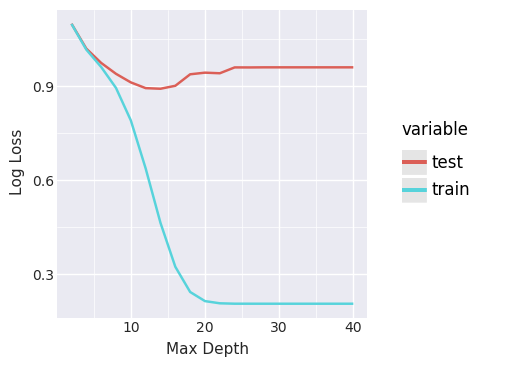

In [1119]:
# Takes a while. Only run if needed, and use as many processes as needed as there is no progress display.

def iteration(i):
    try:
        clf = RandomForestClassifier(n_estimators=100, max_depth=i, 
                                     random_state=8, max_features='auto')
        loss = TrainTest([], [])
        run_classifier_CV(clf, train, test, target_names, loss)
        return (i, sum(loss.train) / n_splits, sum(loss.test) / n_splits)
    except:
        import traceback
        traceback.print_exc()

range_ = range(2, 42, 2)
p = Pool(processes=8)
result = p.map(iteration, range_)
p.close()
p.join()

plot_hypervariable(result, 'Max Depth')

In [1112]:
data.iloc[:, 1:].columns.size

52

Now, with the above information, let's try to tune for other hyperparameters like bootstraping, criterion, max_features, and the minimum number of samples per split. It turns out some of these don't seem to change as we search this hyperparameter space using grid search.

In [1146]:
X = data.loc[:, columns]
t = data.OutcomeType

param = [{'n_estimators': [250],             # 100 < 250 -- In all cases seen
          'max_depth': [13, 14, 15],
#           'criterion': ['gini', 'entropy'],# entropy < gini -- ditto
          'max_features': ['sqrt'],
          'bootstrap': [False],              # True < False -- ditto
          'min_samples_split': [2, 3, 4]}]

rf_clf = RandomForestClassifier(random_state=8)

clf = GridSearchCV(rf_clf, param, scoring=ln_loss_scorer, n_jobs=-1,
                   cv=skf_generator(data, n_splits), verbose=1)

clf.fit(X, t)

print_grid_cv_results(clf, X, t)

Fitting 8 folds for each of 9 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  2.3min finished


,score,95% CI,bootstrap,n_estimators,min_samples_split,max_features,max_depth
5,-0.787,+/- 0.029,False,250,4,sqrt,14
7,-0.787,+/- 0.037,False,250,3,sqrt,15
6,-0.788,+/- 0.032,False,250,2,sqrt,15
8,-0.789,+/- 0.033,False,250,4,sqrt,15
3,-0.789,+/- 0.037,False,250,2,sqrt,14
4,-0.791,+/- 0.037,False,250,3,sqrt,14
0,-0.794,+/- 0.031,False,250,2,sqrt,13
2,-0.794,+/- 0.031,False,250,4,sqrt,13
1,-0.795,+/- 0.033,False,250,3,sqrt,13


Ideally, for random forest we shouldn't high correlations between our features, otherwise when considers randomly one over the other at a split we might increase our variance quite a bit. Correlations seem to be fairly low despite most being positive.

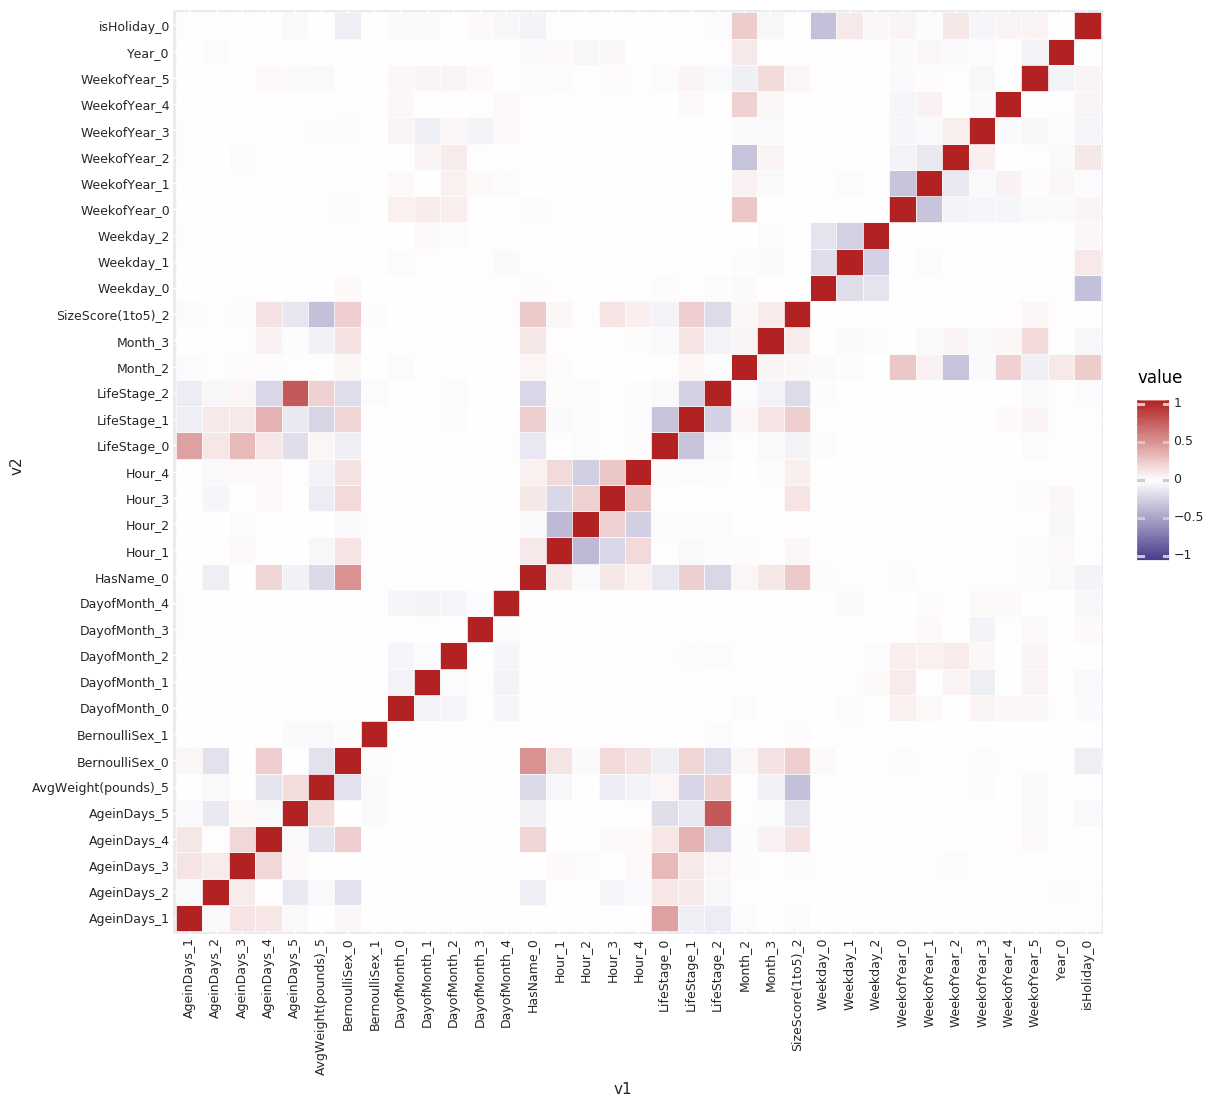

In [1144]:
df_corr = df_bin.loc[:, columns].corr()
df_corr = df_corr.stack().reset_index()
df_corr.columns = ['v1','v2','value']

(ggplot(df_corr, aes(x='v1', y='v2', fill='value'))
 + geom_tile(color='white', size=0.25)
 + scale_fill_gradientn(colors=('darkslateblue', 'white', 'firebrick'), limits=(-1,1))
 + theme_seaborn()
 + theme(axis_text_x = element_text(angle = 90, size=9),
         axis_text_y = element_text(size=9))
 + coord_equal()
).draw().set_size_inches(12,12)

Using the information above from the hyperparameter tuning, let's increase the number of trees to 1000 and print out more detailed information about the performance of this classifer. Also I'd expect that we'd liekly see an improvement to the mean score and variance with a higher number of trees. So it should be worth the extra training time.


Fold 1 of 8
Train log loss: 0.340540815373
Test log loss: 0.785801274674
                 precision    recall  f1-score   support

       Adoption       0.67      0.86      0.75      1198
           Died       0.00      0.00      0.00        22
     Euthanasia       0.70      0.13      0.22       175
Return_to_owner       0.50      0.44      0.47       530
       Transfer       0.78      0.71      0.74      1046

    avg / total       0.68      0.68      0.66      2971

Classifier score (accuracy): 0.680915516661


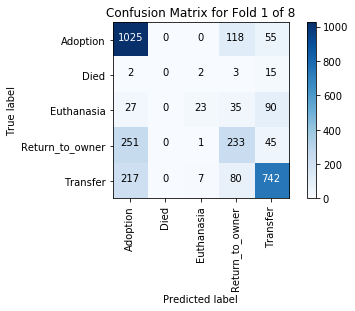

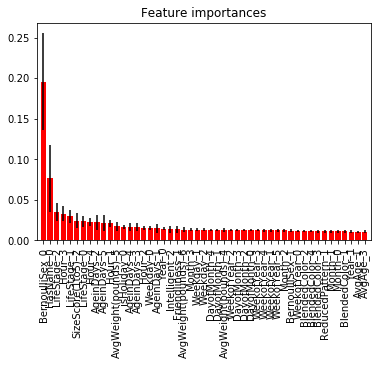


Fold 2 of 8
Train log loss: 0.340283456202
Test log loss: 0.792970097687
                 precision    recall  f1-score   support

       Adoption       0.67      0.86      0.75      1198
           Died       0.00      0.00      0.00        22
     Euthanasia       0.57      0.10      0.17       175
Return_to_owner       0.52      0.47      0.49       530
       Transfer       0.77      0.69      0.73      1046

    avg / total       0.67      0.68      0.66      2971

Classifier score (accuracy): 0.677549646584


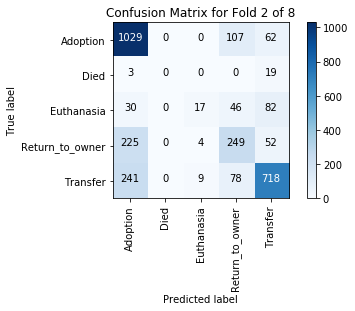

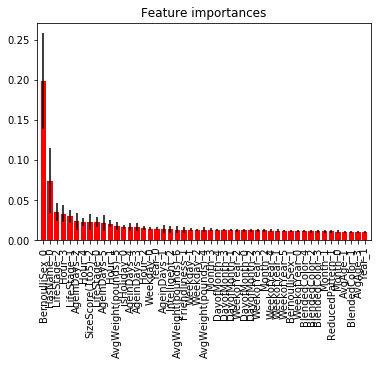


Fold 3 of 8
Train log loss: 0.339482646669
Test log loss: 0.799026871081
                 precision    recall  f1-score   support

       Adoption       0.69      0.88      0.77      1198
           Died       0.00      0.00      0.00        22
     Euthanasia       0.45      0.10      0.16       175
Return_to_owner       0.51      0.40      0.45       530
       Transfer       0.77      0.72      0.74      1046

    avg / total       0.66      0.68      0.66      2971

Classifier score (accuracy): 0.684281386738


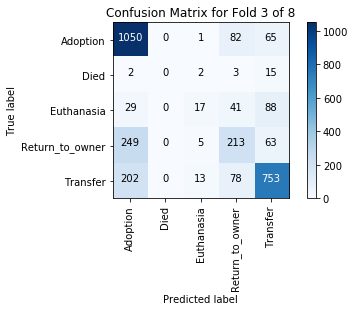

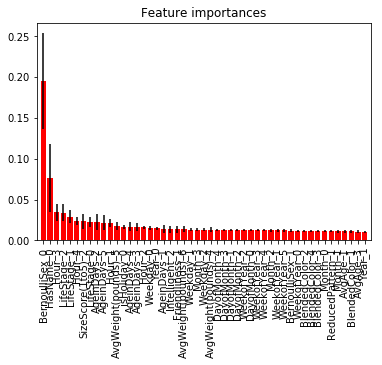


Fold 4 of 8
Train log loss: 0.339397529979
Test log loss: 0.80464203731
                 precision    recall  f1-score   support

       Adoption       0.68      0.85      0.75      1198
           Died       0.00      0.00      0.00        22
     Euthanasia       0.52      0.07      0.12       175
Return_to_owner       0.50      0.44      0.47       530
       Transfer       0.76      0.71      0.73      1046

    avg / total       0.66      0.68      0.65      2971

Classifier score (accuracy): 0.67653988556


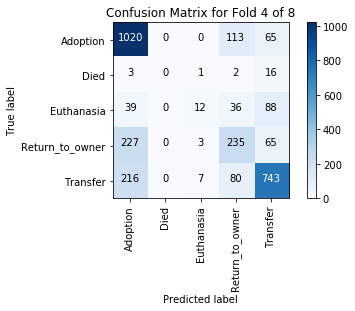

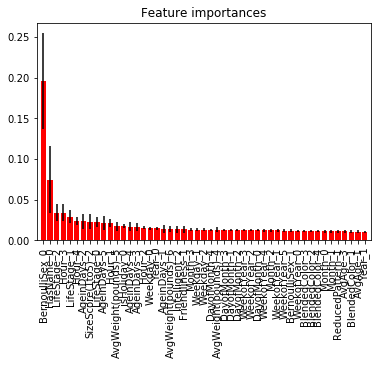


Fold 5 of 8
Train log loss: 0.340649842567
Test log loss: 0.789732174538
                 precision    recall  f1-score   support

       Adoption       0.69      0.87      0.77      1198
           Died       1.00      0.05      0.09        22
     Euthanasia       0.84      0.12      0.21       175
Return_to_owner       0.50      0.44      0.47       530
       Transfer       0.76      0.71      0.73      1046

    avg / total       0.69      0.68      0.66      2971

Classifier score (accuracy): 0.684617973746


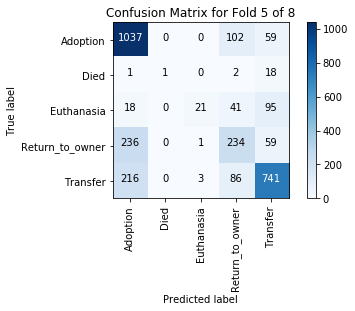

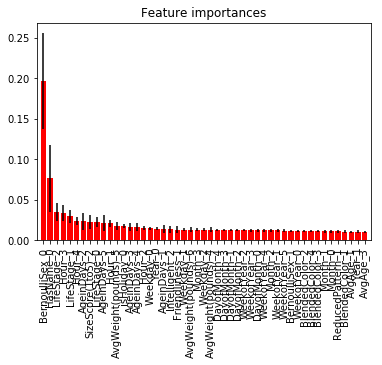


Fold 6 of 8
Train log loss: 0.34236235821
Test log loss: 0.76325061063
                 precision    recall  f1-score   support

       Adoption       0.69      0.87      0.77      1198
           Died       0.00      0.00      0.00        21
     Euthanasia       0.76      0.17      0.27       175
Return_to_owner       0.50      0.44      0.47       530
       Transfer       0.78      0.72      0.75      1046

    avg / total       0.69      0.69      0.67      2970

Classifier score (accuracy): 0.691245791246


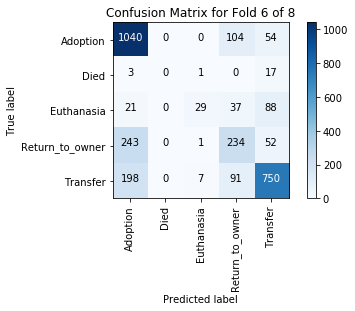

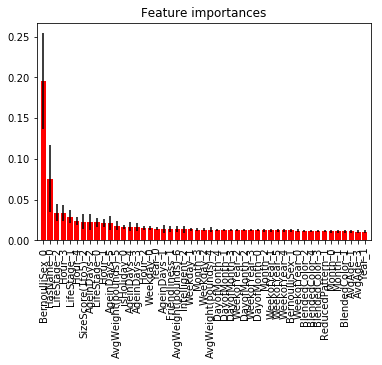


Fold 7 of 8
Train log loss: 0.342874023812
Test log loss: 0.766491352641
                 precision    recall  f1-score   support

       Adoption       0.68      0.85      0.76      1197
           Died       1.00      0.05      0.09        21
     Euthanasia       0.67      0.13      0.21       174
Return_to_owner       0.47      0.43      0.45       530
       Transfer       0.79      0.72      0.75      1046

    avg / total       0.68      0.68      0.67      2968

Classifier score (accuracy): 0.682614555256


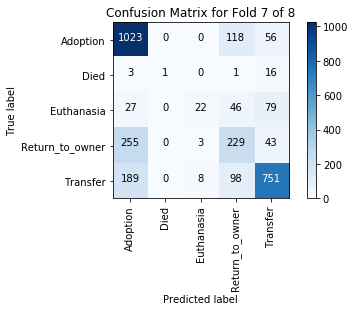

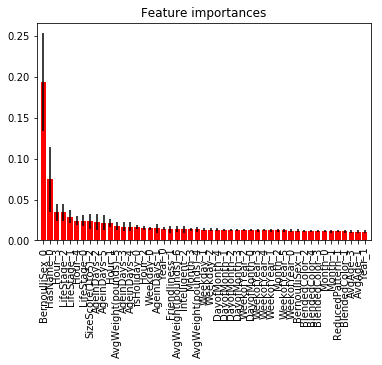


Fold 8 of 8
Train log loss: 0.339478479292
Test log loss: 0.775041197865
                 precision    recall  f1-score   support

       Adoption       0.69      0.86      0.76      1197
           Died       1.00      0.05      0.09        21
     Euthanasia       0.81      0.15      0.25       174
Return_to_owner       0.52      0.46      0.49       529
       Transfer       0.76      0.71      0.74      1045

    avg / total       0.69      0.69      0.67      2966

Classifier score (accuracy): 0.687120701281


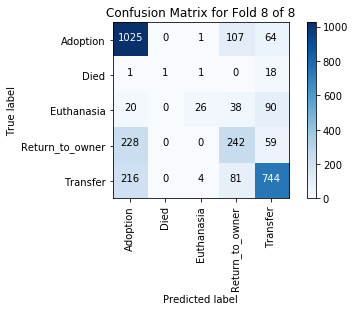

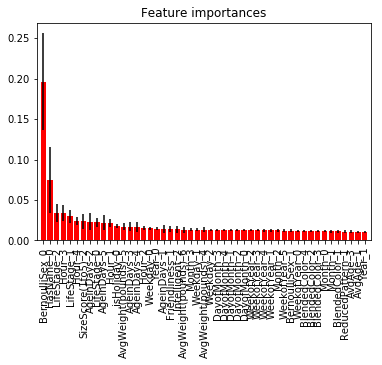

Avg. train log loss: 0.340633644013 +/- 0.00243293203947
Avg. test log loss: 0.784619452053 +/- 0.0275687245809


In [1149]:
rf_clf = RandomForestClassifier(n_estimators=1000, max_depth=14, bootstrap=False, 
                                min_samples_split=4, random_state=8,
                                n_jobs=-1)

loss = TrainTest([], [])

clfs = run_classifier_CV(rf_clf, 
                         [x.loc[:, ['OutcomeType'] + columns] for x in train], 
                         [x.loc[:, ['OutcomeType'] + columns] for x in test], 
                         target_names, loss, plot=True)

print('Avg. train log loss: {} +/- {}'.format(np.mean(loss.train), np.std(loss.train) * 1.96))
print('Avg. test log loss: {} +/- {}'.format(np.mean(loss.test), np.std(loss.test)* 1.96))

If we peak at the hold_out data we can use it to see if we get an improvement in the scores when soft voting via bagging on the k folds used for training compared to simply training with all available data. As this is the only purpose of this peak it should be okay. This will help us see if there is potential value in using bagging in this case or if it's just better to train with all our data. If the difference is small it might be better to avoid bagging if we decide to use an esemble method (like combining RF with other classifiers) for simplicity.

WITH Soft Voting on Folds:

Test log loss: 0.771633249011
                 precision    recall  f1-score   support

       Adoption       0.69      0.87      0.77      1187
           Died       0.00      0.00      0.00        24
     Euthanasia       0.77      0.15      0.26       157
Return_to_owner       0.54      0.46      0.50       547
       Transfer       0.79      0.73      0.76      1055

    avg / total       0.70      0.70      0.68      2970

WITHOUT Soft Voting on Folds:

Test log loss: 0.770343860034
                 precision    recall  f1-score   support

       Adoption       0.69      0.87      0.77      1187
           Died       0.00      0.00      0.00        24
     Euthanasia       0.82      0.18      0.29       157
Return_to_owner       0.53      0.46      0.49       547
       Transfer       0.80      0.73      0.76      1055

    avg / total       0.70      0.70      0.68      2970



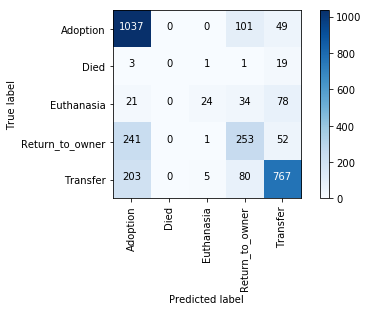

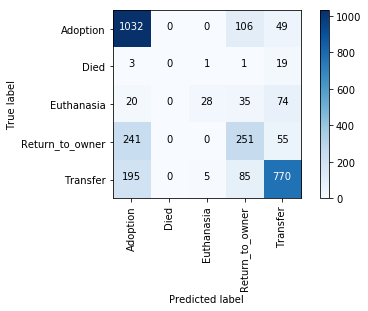

In [1151]:
print("WITH Soft Voting on Folds:")

X = TrainTest(data.loc[:, columns], hold_out.loc[:, columns])
t = TrainTest(data.OutcomeType, hold_out.OutcomeType)
pred_proba = average([clfs[i].predict_proba(X.test) for i in range(n_splits)], axis=0)
pred = TrainTest(None, [target_names[argmax(pred_proba[i])] for i in range(len(X.test))])
loss = TrainTest(None, [calc_ln_loss(t.test, pred_proba, target_names)])
plot_results(X, t, target_names, loss, pred, 1, show_title=False)

print("WITHOUT Soft Voting on Folds:")
rf_clf.fit(X.train, t.train)
pred_proba = TrainTest(None, rf_clf.predict_proba(X.test))
pred = TrainTest(None, [target_names[argmax(pred_proba.test[i])] for i in range(len(X.test))])
loss = TrainTest(None, [calc_ln_loss(t.test, pred_proba.test, target_names)])
plot_results(X, t, target_names, loss, pred, 1, show_title=False)


In [ ]:
X = data.iloc[:, 1:]
t = data.OutcomeType

param = [{'n_estimators': [50, 75, 100],
          'learning_rate': [0.3, 0.1],
          'max_depth': [6, 7, 8],
          'subsample': [.9, 0.875, 0.8]}]

gb_clf = GradientBoostingClassifier(random_state=8)

clf = GridSearchCV(gb_clf, param, scoring=ln_loss_scorer, n_jobs=-1,
                   cv=skf_generator(data, n_splits), verbose=1)

clf.fit(X, t)

print_grid_cv_results(clf, X, t)

Fitting 8 folds for each of 54 candidates, totalling 432 fits



Fold 1 of 8
Train log loss: 0.436376552857
Test log loss: 0.757591341306
                 precision    recall  f1-score   support

       Adoption       0.71      0.81      0.75      1198
           Died       0.50      0.14      0.21        22
     Euthanasia       0.68      0.24      0.35       175
Return_to_owner       0.49      0.50      0.49       530
       Transfer       0.77      0.73      0.75      1046

    avg / total       0.69      0.69      0.68      2971

Classifier score (accuracy): 0.686637495793

Fold 2 of 8
Train log loss: 0.438717469808
Test log loss: 0.759855897268
                 precision    recall  f1-score   support

       Adoption       0.71      0.81      0.76      1198
           Died       0.60      0.14      0.22        22
     Euthanasia       0.56      0.27      0.37       175
Return_to_owner       0.53      0.54      0.54       530
       Transfer       0.77      0.72      0.74      1046

    avg / total       0.69      0.69      0.69      2971

Clas

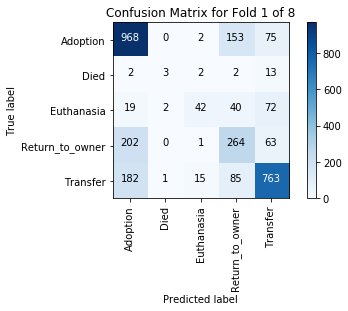

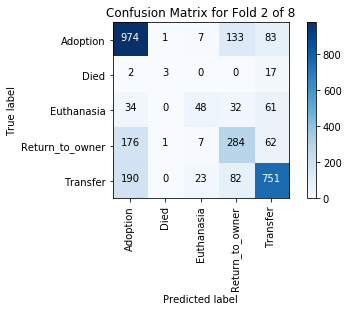

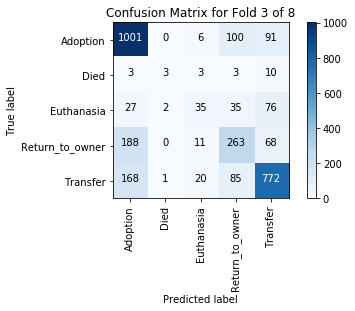

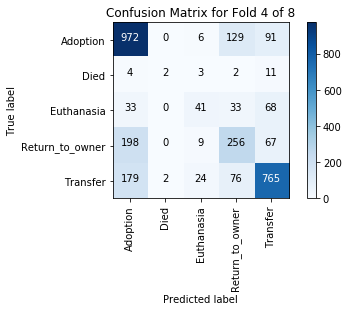

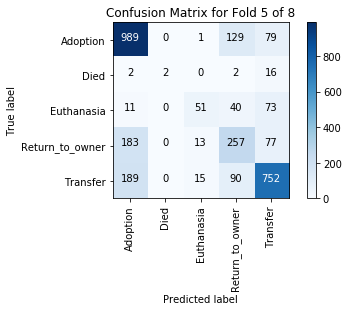

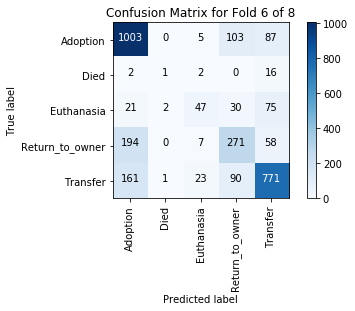

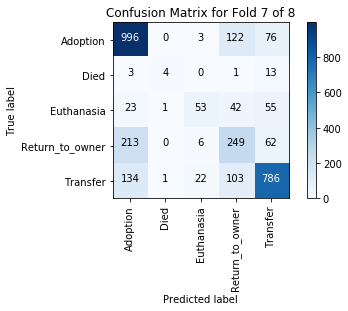

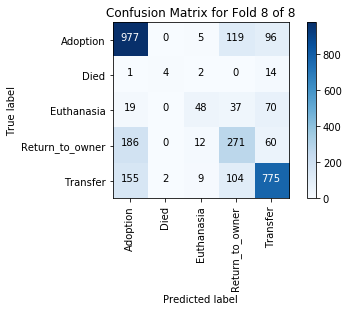

In [87]:
gb_clf = GradientBoostingClassifier(n_estimators=50, max_depth=8, subsample=0.875, random_state=8)

loss = TrainTest([], [])
clfs = run_classifier_CV(gb_clf, train, test, target_names, loss, plot=True)

print('Avg. train log loss: {} +/- {}'.format(np.mean(loss.train), np.std(loss.train) * 1.96))
print('Avg. test log loss: {} +/- {}'.format(np.mean(loss.test), np.std(loss.test)* 1.96))

GB and RF log loss are similar (although with the current tuning RF is better). However, GB seems to do better on Died and Euthanized, so maybe an ensemble of the two will be helpufl?

In [88]:
voting_clf = VotingClassifier([('rf', rf_clf), ('gb', gb_clf)], voting='soft', n_jobs=-1)

# score using cross validation
clf_list = [rf_clf, gb_clf, voting_clf]
name_list = ['Random Forest', 'Gradient Boosting', 'Ensemble']

for clf, name in zip(clf_list,name_list) :
    scores = cross_val_score(clf, X, t, scoring=ln_loss_scorer, cv=skf_generator(data, n_splits))
    print("Log Loss: %0.3f +/- %0.3f (%s 95%% CI)" % (scores.mean(), scores.std()*1.96, name))

Log Loss: -0.739 +/- 0.027 (Random Forest 95% CI)
Log Loss: -0.748 +/- 0.029 (Gradient Boosting 95% CI)
Log Loss: -0.730 +/- 0.025 (Ensemble 95% CI)
